# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [9]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [10]:
time.sleep(10)

url = "https://ycharts.com/companies/TSLA/revenues"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
response = requests.get(url, headers=headers)

web_content = response.text
soup = BeautifulSoup(web_content, "html.parser")

tables = soup.find_all("div", class_ = "panel-content")


if tables:
  for each in tables:
    divs_rows = each.find_all("div", class_ = "row")
    
    for each in divs_rows:
      table = each.find_all("div", class_ = "table")

# Creamos DataFrame

tesla_revenue = pd.DataFrame(columns = ["Date", "Revenue"])

for each in table:
  rows = each.find_all("tr")

  for each in rows:
    cols = each.find_all("td")
    if len(cols) == 2:
            date = cols[0].get_text(strip=True)
            revenue = cols[1].get_text(strip=True)
            tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
          "Date": date,
          "Revenue": revenue
      }, index = [0])], ignore_index = True)

tesla_revenue

,Date,Revenue


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Configuración del user-agent y URL
url = "https://ycharts.com/companies/TSLA/revenues"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
response = requests.get(url, headers=headers)

# Parsear el contenido HTML
if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Buscar todas las tablas
    table = soup.find("table")  # Suponemos que la tabla principal tiene el tag <table>
    
    if table:
        rows = table.find_all("tr")  # Buscar todas las filas dentro de la tabla
        data = []

        # Extraer datos de las filas
        for row in rows[1:]:  # Saltamos la cabecera
            cols = row.find_all("td")
            if len(cols) == 2:
                date = cols[0].get_text(strip=True)
                revenue = cols[1].get_text(strip=True)
                data.append({"Date": date, "Revenue": revenue})

        # Crear DataFrame
        tesla_revenue = pd.DataFrame(data)
        print(tesla_revenue)
    else:
        print("No se encontró ninguna tabla en el HTML.")
else:
    print("No se pudo acceder a la página web.")


                  Date Revenue
0   September 30, 2024  25.18B
1        June 30, 2024  25.50B
2       March 31, 2024  21.30B
3    December 31, 2023  25.17B
4   September 30, 2023  23.35B
5        June 30, 2023  24.93B
6       March 31, 2023  23.33B
7    December 31, 2022  24.32B
8   September 30, 2022  21.45B
9        June 30, 2022  16.93B
10      March 31, 2022  18.76B
11   December 31, 2021  17.72B
12  September 30, 2021  13.76B
13       June 30, 2021  11.96B
14      March 31, 2021  10.39B
15   December 31, 2020  10.74B
16  September 30, 2020  8.771B
17       June 30, 2020  6.036B
18      March 31, 2020  5.985B
19   December 31, 2019  7.384B
20  September 30, 2019  6.303B
21       June 30, 2019   6.35B
22      March 31, 2019  4.541B
23   December 31, 2018  7.226B
24  September 30, 2018  6.824B


LIMPIEZA Y SQLITE

In [10]:
# Limpieza de la columna Revenue
def parse_revenue(value):
    if "B" in value:  # Billones
        return float(value.replace("B", "").replace(",", "").strip()) * 1e9
    elif "M" in value:  # Millones
        return float(value.replace("M", "").replace(",", "").strip()) * 1e6
    else:  # Otros casos (valores numéricos simples)
        return float(value.replace(",", "").strip())

# Aplicar la función a la columna Revenue
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].apply(parse_revenue)

# Convertir valores limpios a float
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype(float)

# Continuar con SQLite
import sqlite3

# Conectar a SQLite
connection = sqlite3.connect("Tesla.db")
cursor = connection.cursor()

# Crear la tabla (si no existe)
cursor.execute("""
CREATE TABLE IF NOT EXISTS revenue (
    Date TEXT,
    Revenue REAL
)
""")

# Insertar datos en la tabla
tesla_tuples = list(tesla_revenue.to_records(index=False))  # Convierte el DataFrame en una lista de tuplas
cursor.executemany("INSERT INTO revenue (Date, Revenue) VALUES (?, ?)", tesla_tuples)

# Guardar cambios
connection.commit()

# Consultar y mostrar los datos almacenados
for row in cursor.execute("SELECT * FROM revenue"):
    print(row)

# Cerrar conexión
connection.close()


('September 30, 2024', 25180000000.0)
('June 30, 2024', 25500000000.0)
('March 31, 2024', 21300000000.0)
('December 31, 2023', 25170000000.0)
('September 30, 2023', 23350000000.0)
('June 30, 2023', 24930000000.0)
('March 31, 2023', 23330000000.0)
('December 31, 2022', 24320000000.0)
('September 30, 2022', 21450000000.0)
('June 30, 2022', 16930000000.0)
('March 31, 2022', 18760000000.0)
('December 31, 2021', 17720000000.0)
('September 30, 2021', 13760000000.0)
('June 30, 2021', 11960000000.0)
('March 31, 2021', 10390000000.0)
('December 31, 2020', 10740000000.0)
('September 30, 2020', 8771000000.0)
('June 30, 2020', 6036000000.0)
('March 31, 2020', 5985000000.0)
('December 31, 2019', 7384000000.0)
('September 30, 2019', 6303000000.0)
('June 30, 2019', 6350000000.0)
('March 31, 2019', 4541000000.0)
('December 31, 2018', 7226000000.0)
('September 30, 2018', 6824000000.0)


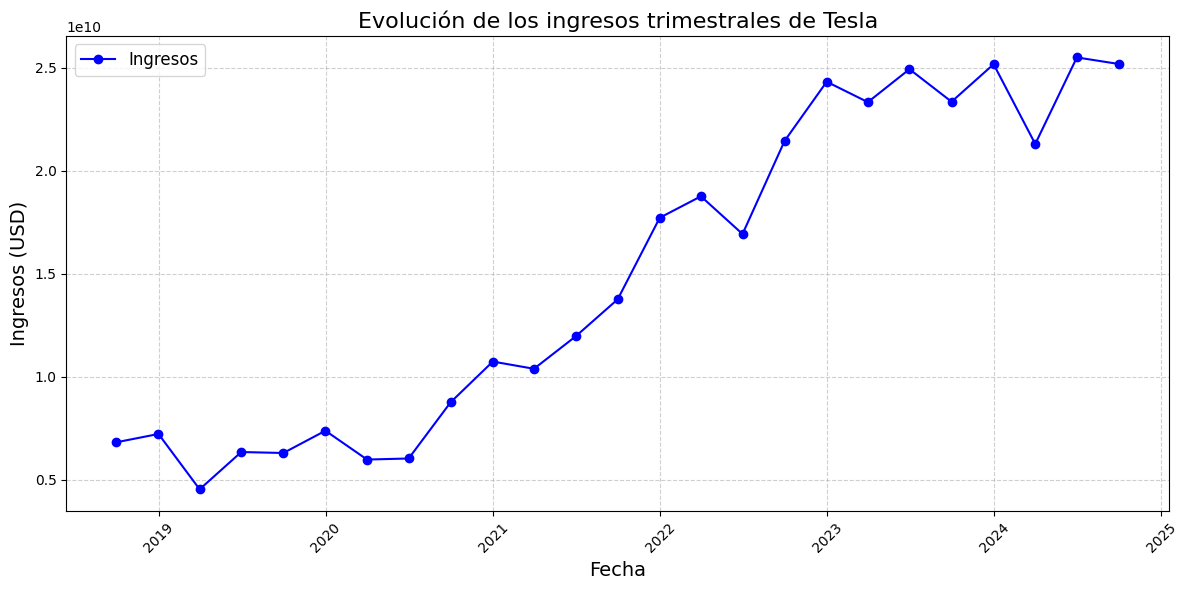

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

# Conectar a SQLite y cargar los datos en un DataFrame
connection = sqlite3.connect("Tesla.db")
query = "SELECT * FROM revenue"
tesla_revenue = pd.read_sql_query(query, connection)

# Convertir la columna Date a tipo datetime y ordenarla
try:
    tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"], format="%B %d, %Y", errors="coerce")
except Exception as e:
    print(f"Error al convertir las fechas: {e}")

# Eliminar filas con fechas no válidas
tesla_revenue = tesla_revenue.dropna(subset=["Date"])
tesla_revenue = tesla_revenue.sort_values(by="Date")

# Crear el gráfico de series de tiempo
plt.figure(figsize=(12, 6))
plt.plot(tesla_revenue["Date"], tesla_revenue["Revenue"], marker='o', color='blue', label="Ingresos")

# Mejorar la visualización
plt.title("Evolución de los ingresos trimestrales de Tesla", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Ingresos (USD)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Cerrar la conexión a la base de datos
connection.close()


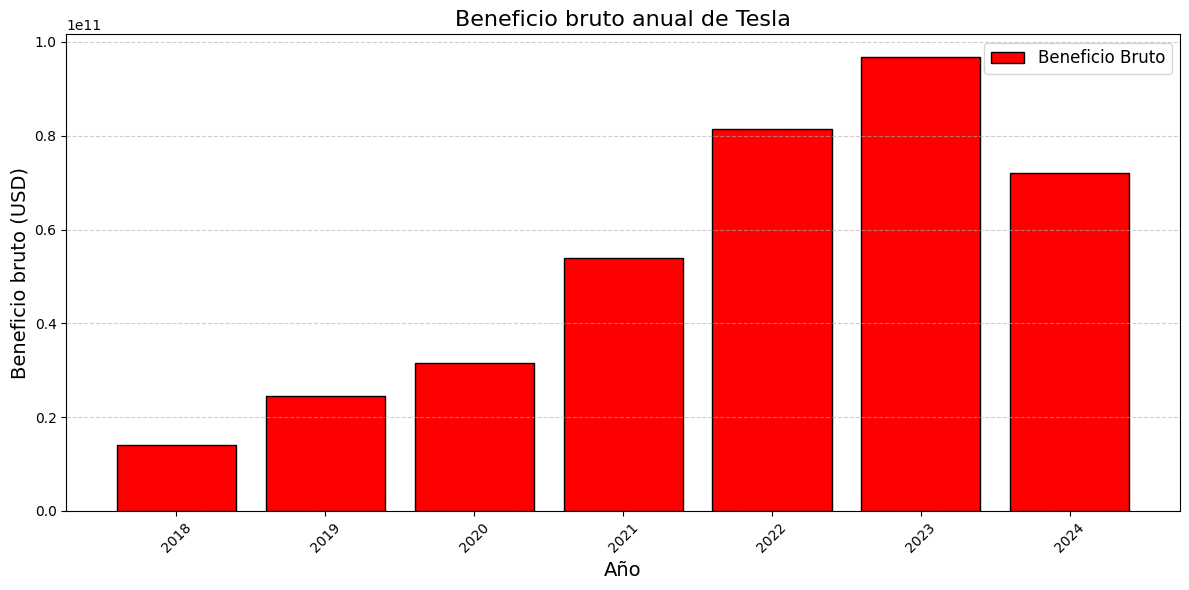

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

# Conectar a SQLite y cargar los datos en un DataFrame
connection = sqlite3.connect("Tesla.db")
query = "SELECT * FROM revenue"
tesla_revenue = pd.read_sql_query(query, connection)

# Convertir la columna Date a tipo datetime y ordenarla
tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"], format="%B %d, %Y", errors="coerce")
tesla_revenue = tesla_revenue.dropna(subset=["Date"])
tesla_revenue = tesla_revenue.sort_values(by="Date")

# Calcular los ingresos anuales (sumando trimestrales)
tesla_revenue["Year"] = tesla_revenue["Date"].dt.year  # Extraer el año
annual_revenue = tesla_revenue.groupby("Year")["Revenue"].sum().reset_index()  # Agrupar por año y sumar

# Crear el gráfico del beneficio bruto anual
plt.figure(figsize=(12, 6))
plt.bar(annual_revenue["Year"], annual_revenue["Revenue"], color='red', edgecolor='black', label="Beneficio Bruto")

# Mejorar la visualización
plt.title("Beneficio bruto anual de Tesla", fontsize=16)
plt.xlabel("Año", fontsize=14)
plt.ylabel("Beneficio bruto (USD)", fontsize=14)
plt.xticks(annual_revenue["Year"], fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Cerrar la conexión a la base de datos
connection.close()


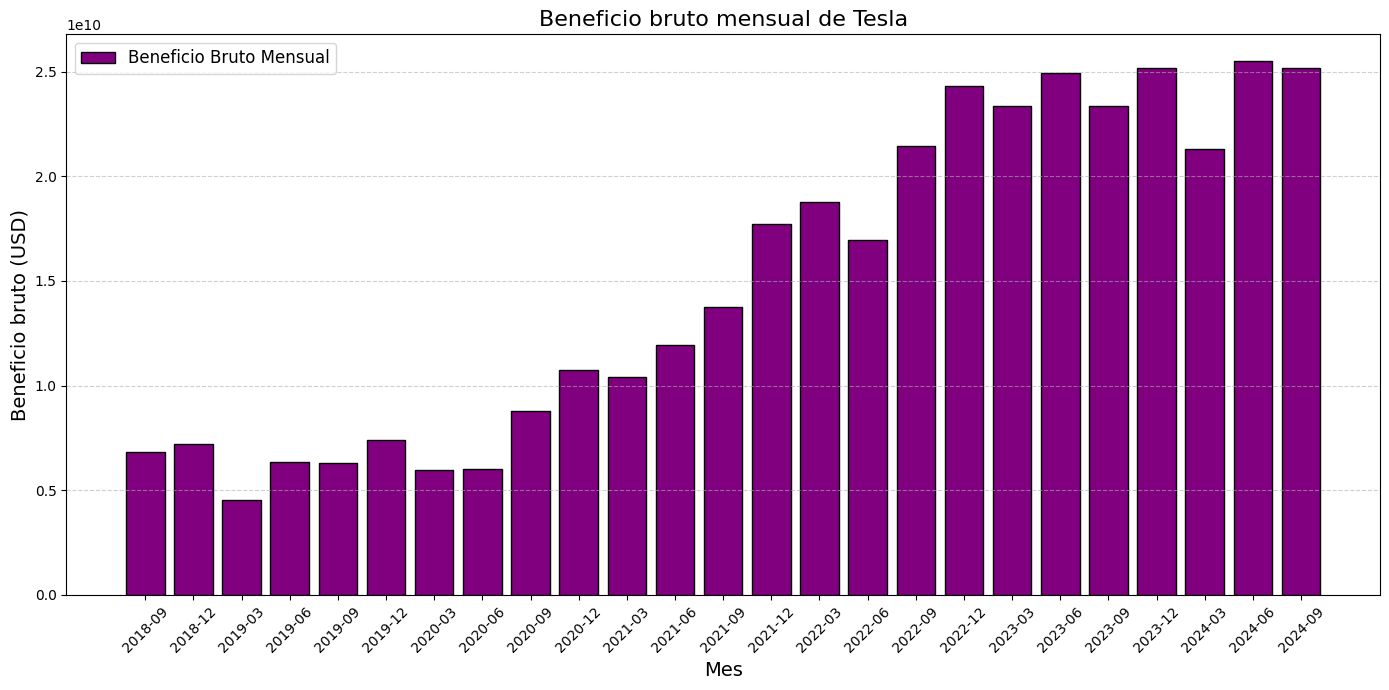

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

# Conectar a SQLite y cargar los datos en un DataFrame
connection = sqlite3.connect("Tesla.db")
query = "SELECT * FROM revenue"
tesla_revenue = pd.read_sql_query(query, connection)

# Convertir la columna Date a tipo datetime y ordenarla
tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"], format="%B %d, %Y", errors="coerce")
tesla_revenue = tesla_revenue.dropna(subset=["Date"])
tesla_revenue = tesla_revenue.sort_values(by="Date")

# Calcular los ingresos mensuales
tesla_revenue["Year-Month"] = tesla_revenue["Date"].dt.to_period("M")  # Crear columna "Año-Mes"
monthly_revenue = tesla_revenue.groupby("Year-Month")["Revenue"].sum().reset_index()  # Sumar ingresos por mes
monthly_revenue["Year-Month"] = monthly_revenue["Year-Month"].astype(str)  # Convertir Period a str para graficar

# Crear el gráfico del beneficio bruto mensual
plt.figure(figsize=(14, 7))
plt.bar(
    monthly_revenue["Year-Month"],
    monthly_revenue["Revenue"],
    color='purple',  # Usar un color diferente (coral)
    edgecolor='black',
    label="Beneficio Bruto Mensual"
)

# Mejorar la visualización
plt.title("Beneficio bruto mensual de Tesla", fontsize=16)
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Beneficio bruto (USD)", fontsize=14)
plt.xticks(fontsize=10, rotation=45)  # Rotar etiquetas de los meses
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

# Cerrar la conexión a la base de datos
connection.close()
